In [21]:
import pandas as pd
import numpy as np
import datetime as dt
import os
from dateutil.relativedelta import relativedelta
import scipy.stats as stats
import math
import textwrap

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt

import matplotlib.pyplot as plt
import pylab
import seaborn as sns
from matplotlib.ticker import PercentFormatter

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.cluster import KMeans
from sklearn import metrics


In [111]:
inpatient=pd.read_csv("Medicare_Provider_Charge_Inpatient_DRG100_FY2011.csv")
outpatient=pd.read_csv("Medicare_Provider_Charge_Outpatient_APC30_CY2011_v2.csv")

In [3]:
inpatient.head()

,DRG Definition,Provider Id,Provider Name,Provider Street Address,Provider City,Provider State,Provider Zip Code,Hospital Referral Region (HRR) Description,Total Discharges,Average Covered Charges,Average Total Payments,Average Medicare Payments
0,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,91,32963.07692,5777.241758,4763.736264
1,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,AL - Birmingham,14,15131.85714,5787.571429,4976.714286
2,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,AL - Birmingham,24,37560.37500,5434.958333,4453.791667
3,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10011,ST VINCENT'S EAST,50 MEDICAL PARK EAST DRIVE,BIRMINGHAM,AL,35235,AL - Birmingham,25,13998.28000,5417.560000,4129.160000
4,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10016,SHELBY BAPTIST MEDICAL CENTER,1000 FIRST STREET NORTH,ALABASTER,AL,35007,AL - Birmingham,18,31633.27778,5658.333333,4851.444444


In [112]:
outpatient.head()

,APC,Provider Id,Provider Name,Provider Street Address,Provider City,Provider State,Provider Zip Code,Hospital Referral Region (HRR) Description,Outpatient Services,Average Estimated Submitted Charges,Average Total Payments
0,0012 - Level I Debridement & Destruction,10029,EAST ALABAMA MEDICAL CENTER AND SNF,2000 PEPPERELL PARKWAY,OPELIKA,AL,36801,AL - Birmingham,23,78.086957,21.910435
1,0012 - Level I Debridement & Destruction,20024,CENTRAL PENINSULA GENERAL HOSPITAL,250 HOSPITAL PLACE,SOLDOTNA,AK,99669,AK - Anchorage,994,149.589749,36.623853
2,0012 - Level I Debridement & Destruction,30064,"UNIVERSITY OF ARIZONA MEDICAL CTR-UNIVERSIT, THE",1501 NORTH CAMPBELL AVENUE,TUCSON,AZ,85724,AZ - Tucson,1765,50.135411,14.541841
3,0012 - Level I Debridement & Destruction,30088,BANNER BAYWOOD MEDICAL CENTER,6644 EAST BAYWOOD AVENUE,MESA,AZ,85206,AZ - Mesa,20,112.400000,23.736000
4,0012 - Level I Debridement & Destruction,30111,"UNIVERSITY OF ARIZONA MEDICAL CTR- SOUTH CAM, THE",2800 EAST AJO WAY,TUCSON,AZ,85713,AZ - Tucson,22,152.045455,16.569091


In [5]:
print(inpatient.shape)
print(outpatient.shape)

(163065, 12)
(43372, 11)


## Part 2: Identify the three providers that are least similar to other providers and the three regions that are least similar to other regions.

### Part 2: A :- Providers Least Like Others

**For Inpatients**<br>
- K-Means Cluster will be used to see if we have any providers that don't fall in with others.<br>
- We will only be keeping identifying features for the k-means clustering.<br>
- Removing Procedure name since only name does not contribute anything significant to the analysis.<br>
- Removing Provider State detail since we will tackle that in Part B of the question

In [11]:
# Adding a New feature - Payout Difference, between Claimed and Reimbursed amount
inpatient["payout_diff"] = inpatient["Average Covered Charges"]-inpatient["Average Total Payments"]

In [13]:
km_in = inpatient[["Total Discharges","Average Covered Charges","Average Total Payments",
                   "Average Medicare Payments","payout_diff"]].copy()
km_in.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163065 entries, 0 to 163064
Data columns (total 5 columns):
Total Discharges             163065 non-null int64
Average Covered Charges      163065 non-null float64
Average Total Payments       163065 non-null float64
Average Medicare Payments    163065 non-null float64
payout_diff                  163065 non-null float64
dtypes: float64(4), int64(1)
memory usage: 6.2 MB


In [15]:
# Standardizing the data, since no missing values
scaler = MinMaxScaler()
scaled_km_in = scaler.fit_transform(km_in)
scaled_km_in.shape

(163065, 5)

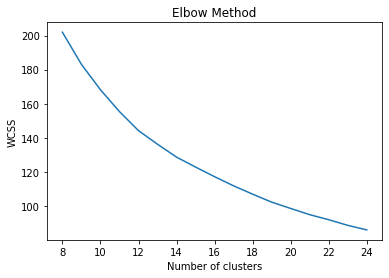

In [18]:
# Using the elbow method to figure out the best number of clusters
wcss = []
for i in range(8,25):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(scaled_km_in)
    wcss.append(kmeans.inertia_)
plt.plot(range(8,25), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

**Elbow seems to occur somewhere around 12. We will create 12 clusters.**

In [22]:
kmeans = KMeans(n_clusters=12, init='k-means++', max_iter=300, n_init=10, random_state=42)
km_12 = kmeans.fit(scaled_km_in)

In [64]:
# Just checking if 13 clusters would be a better option
kmeans_13 = KMeans(n_clusters=13, init='k-means++', max_iter=300, n_init=10, random_state=42)
km_13 = kmeans_13.fit(scaled_km_in)

In [65]:
print("Silhoutte Score 12 clusters: ",metrics.silhouette_score(scaled_km_in, km_12.labels_))
print("Silhoutte Score 13 clusters: ",metrics.silhouette_score(scaled_km_in, km_13.labels_))

Silhoutte Score 12 clusters:  0.3305466819823713
Silhoutte Score 13 clusters:  0.32175625110161193


Since SC for 12 clusters is higher, we will use 12

In [44]:
km_in = inpatient[["Provider Name","Total Discharges","Average Covered Charges","Average Total Payments",
                   "Average Medicare Payments","payout_diff"]].copy()
km_in.set_index("Provider Name",inplace=True)

In [45]:
km_in['cluster'] = km_12.labels_
inpatient['cluster'] = km_12.labels_

In [41]:
# Checking how many of the providers each cluster hold
km_in.cluster.value_counts()*100/sum(km_in.cluster.value_counts())
# The distribution is good

0     37.247110
4     19.368963
8     12.488272
6     12.258302
3      6.379665
11     4.790114
9      2.243277
1      2.226106
10     1.517186
7      0.903934
2      0.417012
5      0.160059
Name: cluster, dtype: float64

In [42]:
km_in.cluster.value_counts()

0     60737
4     31584
8     20364
6     19989
3     10403
11     7811
9      3658
1      3630
10     2474
7      1474
2       680
5       261
Name: cluster, dtype: int64

In [43]:
size=pd.concat([pd.Series(km_in.cluster.size), pd.Series.sort_index(km_in.cluster.value_counts())])
Seg_size=pd.DataFrame(size, columns=['Seg_size'])
Seg_Pct = pd.DataFrame(size/km_in.cluster.size, columns=['Seg_Pct'])

In [51]:
Profling_output = pd.concat([km_in.apply(lambda x: x.mean()).T,
                             km_in.groupby('cluster').apply(lambda x: x.mean()).T],axis=1)

Profling_output=pd.concat([Seg_size.T, Seg_Pct.T, Profling_output], axis=0)
Profling_output

,0,0,1,2,3,4,5,6,7,8,9,10,11
Seg_size,163065.000000,60737.000000,3630.000000,680.000000,10403.000000,31584.000000,261.000000,19989.000000,1474.000000,20364.000000,3658.000000,2474.000000,7811.000000
Seg_Pct,1.000000,0.372471,0.022261,0.004170,0.063797,0.193690,0.001601,0.122583,0.009039,0.124883,0.022433,0.015172,0.047901
Total Discharges,42.776304,37.974530,28.714050,30.004412,42.671441,38.984043,23.731801,40.814598,26.143148,39.881261,36.465008,309.267179,38.127128
Average Covered Charges,36133.958434,16095.330337,96703.295821,137312.104654,76434.482064,21161.454565,377729.671542,37530.214721,208036.824703,42047.689534,125714.366789,32961.220372,58070.901554
Average Total Payments,9707.477867,4916.354358,34382.464076,56875.674581,12510.418263,8225.447095,60498.017116,12745.070388,38148.155072,7034.065644,20337.420445,10035.970921,20698.565399
Average Medicare Payments,8494.495174,3898.029043,31917.339968,53625.795197,11095.980461,7201.764270,57645.178244,11428.519061,35557.354117,5932.132239,18446.241401,8634.306651,18901.754921
payout_diff,26426.480568,11178.975979,62320.831745,80436.430073,63924.063801,12936.007471,317231.654426,24785.144333,169888.669631,35013.623890,105376.946344,22925.249451,37372.336155
cluster,3.683114,0.000000,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000,10.000000,11.000000


In [56]:
Profling_output.columns = ['Overall','Cluster1', 'Cluster2', 'Cluster3', 'Cluster4','Cluster5', 'Cluster6', 'Cluster7',
                           'Cluster8','Cluster9','Cluster10','Cluster11','Cluster12']
Profling_output.to_excel("analysis_result/inpatient_cluster1.xlsx")

In [89]:
inpatient[inpatient['cluster']==5].to_excel("analysis_result/inpatient_cluster.xlsx",sheet_name="data")

**Cluster 6** providers seem to be the most different.
1. Its the smallest cluster as compared to others
2. Inspite of having least number of discharges, these providers have the highest margins for Claims and Reimbursements.

**Now for Outpatients**<br>

In [114]:
outpatient.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43372 entries, 0 to 43371
Data columns (total 11 columns):
APC                                           43372 non-null object
Provider Id                                   43372 non-null int64
Provider Name                                 43372 non-null object
Provider Street Address                       43372 non-null object
Provider City                                 43372 non-null object
Provider State                                43372 non-null object
Provider Zip Code                             43372 non-null int64
Hospital Referral Region (HRR) Description    43372 non-null object
Outpatient Services                           43372 non-null int64
Average  Estimated Submitted Charges          43372 non-null float64
Average Total Payments                        43372 non-null float64
dtypes: float64(2), int64(3), object(6)
memory usage: 3.6+ MB


In [115]:
outpatient["payout_diff"] = outpatient["Average  Estimated Submitted Charges"]-outpatient["Average Total Payments"]

In [116]:
km_out = outpatient[["Outpatient Services","Average  Estimated Submitted Charges","Average Total Payments"
                    ,"payout_diff"]].copy()
km_out.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43372 entries, 0 to 43371
Data columns (total 4 columns):
Outpatient Services                     43372 non-null int64
Average  Estimated Submitted Charges    43372 non-null float64
Average Total Payments                  43372 non-null float64
payout_diff                             43372 non-null float64
dtypes: float64(3), int64(1)
memory usage: 1.3 MB


In [117]:
#Standardizing the columns
scaled_km_out = scaler.fit_transform(km_out)

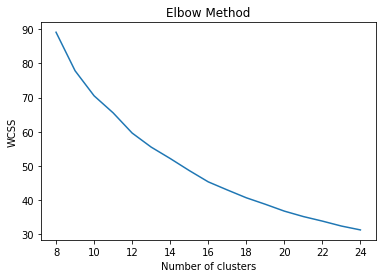

In [119]:
# Using the elbow method to figure out the best number of clusters
wcss = []
for i in range(8,25):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(scaled_km_out)
    wcss.append(kmeans.inertia_)
plt.plot(range(8,25), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

**Elbow seems to occur somewhere around 12 & 16. We will create both clusters just to confirm the SC**

In [120]:
kmeans_out_12 = KMeans(n_clusters=12, init='k-means++', max_iter=300, n_init=10, random_state=42)
km_out_12 = kmeans_out_12.fit(scaled_km_out)

In [121]:
kmeans_out_16 = KMeans(n_clusters=16, init='k-means++', max_iter=300, n_init=10, random_state=42)
km_out_16 = kmeans_out_16.fit(scaled_km_out)

In [122]:
print("Silhoutte Score 12 clusters: ",metrics.silhouette_score(scaled_km_out, km_out_12.labels_))
print("Silhoutte Score 16 clusters: ",metrics.silhouette_score(scaled_km_out, km_out_16.labels_))

Silhoutte Score 12 clusters:  0.46952111102906297
Silhoutte Score 16 clusters:  0.4102460911937158


12 clusters seem to give the best score, hence we will go ahead with that

In [129]:
km_out['cluster'] = km_out_12.labels_
outpatient['cluster'] = km_out_12.labels_

In [124]:
# Checking how many of the providers each cluster hold
km_out.cluster.value_counts()*100/sum(km_out.cluster.value_counts())

6     45.699991
0     16.946417
5      8.791386
9      7.444895
1      7.424145
10     5.648806
2      3.495343
3      2.524670
8      0.800055
7      0.717052
11     0.274371
4      0.232869
Name: cluster, dtype: float64

In [125]:
size=pd.concat([pd.Series(km_out.cluster.size), pd.Series.sort_index(km_out.cluster.value_counts())])
Seg_size=pd.DataFrame(size, columns=['Seg_size'])
Seg_Pct = pd.DataFrame(size/km_out.cluster.size, columns=['Seg_Pct'])

In [126]:
Profling_output_o = pd.concat([km_out.apply(lambda x: x.mean()).T,
                             km_out.groupby('cluster').apply(lambda x: x.mean()).T],axis=1)

Profling_output_o=pd.concat([Seg_size.T, Seg_Pct.T, Profling_output_o], axis=0)
Profling_output_o

,0,0,1,2,3,4,5,6,7,8,9,10,11
Seg_size,43372.000000,7350.000000,3220.000000,1516.000000,1095.000000,101.000000,3813.000000,19821.000000,311.000000,347.000000,3229.000000,2450.000000,119.000000
Seg_Pct,1.000000,0.169464,0.074241,0.034953,0.025247,0.002329,0.087914,0.457000,0.007171,0.008001,0.074449,0.056488,0.002744
Outpatient Services,587.980955,254.788844,192.766770,220.600923,139.632877,20.504950,381.305796,683.096211,28.797428,106.259366,203.782595,376.457551,49574.546218
Average Estimated Submitted Charges,1473.994047,990.712658,2011.077480,5647.559015,5034.606764,12819.095561,1479.810735,320.691740,5333.007199,10531.748999,3075.280058,3079.986478,128.253338
Average Total Payments,265.425586,158.894561,522.611794,755.928855,490.000497,1469.640138,362.324602,76.689351,1462.169533,667.841362,744.267905,338.574263,80.286812
payout_diff,1208.568461,831.818096,1488.465687,4891.630160,4544.606267,11349.455423,1117.486132,244.002388,3870.837667,9863.907637,2331.012153,2741.412214,47.966526
cluster,4.790072,0.000000,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000,10.000000,11.000000


In [127]:
Profling_output_o.columns = ['Overall','Cluster1', 'Cluster2', 'Cluster3', 'Cluster4','Cluster5', 'Cluster6', 'Cluster7',
                           'Cluster8','Cluster9','Cluster10','Cluster11','Cluster12']
Profling_output_o.to_excel("analysis_result/outpatient_cluster.xlsx")

In [130]:
outpatient[outpatient['cluster']==4].to_excel("analysis_result/outpatient_cluster_5.xlsx",sheet_name="data")

**Cluster 5** providers seem to be the most different.
1. Its the smallest cluster as compared to others
2. Inspite of having least number of discharges, these providers have the highest margins for Claims and Reimbursements. They also seem to be exclusively clustered around the procedures that had most cost variations (Level IV Endoscopy of upper Airway and Nerve Injections)

### Part 2: B :- Region Least Like Others
Similarly carrying out the analysis for Region/State<br><br>
**For Inpatient**

In [135]:
# Grouping data by Region
inp_reg = inpatient.groupby(["Provider State","DRG Definition"]).agg({"Total Discharges":'sum',
                                                    "Average Covered Charges":'mean',
                                                    "Average Total Payments":'mean',
                                                    "Average Medicare Payments":'mean'}).reset_index()
inp_reg.head()

,Provider State,DRG Definition,Total Discharges,Average Covered Charges,Average Total Payments,Average Medicare Payments
0,AK,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,23,34805.130430,8401.956522,6413.782609
1,AK,057 - DEGENERATIVE NERVOUS SYSTEM DISORDERS W/...,11,31858.545450,8799.000000,8081.545455
2,AK,064 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,45,42453.811500,21608.014705,20555.263370
3,AK,065 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,152,32629.374418,12555.554007,11140.966651
4,AK,066 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,84,25843.327917,9275.869506,8258.430631


In [136]:
inp_reg["payout_diff"] = inp_reg["Average Covered Charges"]-inp_reg["Average Total Payments"]
inp_reg.head()

,Provider State,DRG Definition,Total Discharges,Average Covered Charges,Average Total Payments,Average Medicare Payments,payout_diff
0,AK,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,23,34805.130430,8401.956522,6413.782609,26403.173908
1,AK,057 - DEGENERATIVE NERVOUS SYSTEM DISORDERS W/...,11,31858.545450,8799.000000,8081.545455,23059.545450
2,AK,064 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,45,42453.811500,21608.014705,20555.263370,20845.796795
3,AK,065 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,152,32629.374418,12555.554007,11140.966651,20073.820411
4,AK,066 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,84,25843.327917,9275.869506,8258.430631,16567.458411


In [137]:
km_reg_in = inp_reg[["Total Discharges","Average Covered Charges","Average Total Payments",
                   "Average Medicare Payments","payout_diff"]].copy()
km_reg_in.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5025 entries, 0 to 5024
Data columns (total 5 columns):
Total Discharges             5025 non-null int64
Average Covered Charges      5025 non-null float64
Average Total Payments       5025 non-null float64
Average Medicare Payments    5025 non-null float64
payout_diff                  5025 non-null float64
dtypes: float64(4), int64(1)
memory usage: 196.4 KB


In [138]:
# Standardizing the data, since no missing values
scaler = MinMaxScaler()
scaled_km_reg_in = scaler.fit_transform(km_reg_in)
scaled_km_reg_in.shape

(5025, 5)

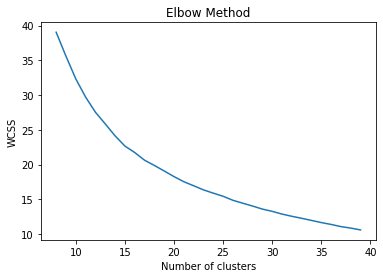

In [141]:
# Using the elbow method to figure out the best number of clusters
wcss = []
for i in range(8,40):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(scaled_km_reg_in)
    wcss.append(kmeans.inertia_)
plt.plot(range(8,40), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

**Elbow seems to occur somewhere around 15 or 17. We will create both clusters and verify the SC.**

In [145]:
kmeans_15 = KMeans(n_clusters=15, init='k-means++', max_iter=300, n_init=10, random_state=42)
km_15 = kmeans_15.fit(scaled_km_reg_in)

In [146]:
kmeans_17 = KMeans(n_clusters=17, init='k-means++', max_iter=300, n_init=10, random_state=42)
km_17 = kmeans_17.fit(scaled_km_reg_in)

In [147]:
print("Silhoutte Score 15 clusters: ",metrics.silhouette_score(scaled_km_reg_in, km_15.labels_))
print("Silhoutte Score 17 clusters: ",metrics.silhouette_score(scaled_km_reg_in, km_17.labels_))

Silhoutte Score 15 clusters:  0.3257434348637761
Silhoutte Score 17 clusters:  0.32041548555401383


In [148]:
kmeans_20 = KMeans(n_clusters=20, init='k-means++', max_iter=300, n_init=10, random_state=42)
km_20 = kmeans_20.fit(scaled_km_reg_in)
print("Silhoutte Score 20 clusters: ",metrics.silhouette_score(scaled_km_reg_in, km_20.labels_))

Silhoutte Score 20 clusters:  0.2878945592843101


In [149]:
kmeans_14 = KMeans(n_clusters=14, init='k-means++', max_iter=300, n_init=10, random_state=42)
km_14 = kmeans_14.fit(scaled_km_reg_in)
print("Silhoutte Score 14 clusters: ",metrics.silhouette_score(scaled_km_reg_in, km_14.labels_))

Silhoutte Score 14 clusters:  0.3281721692850932


14 clusters have the best SC, we will use this going forward

In [150]:
km_reg_in['cluster'] = km_14.labels_

In [154]:
inp_reg['cluster'] = km_14.labels_

In [151]:
# Checking how many of the providers each cluster hold
km_reg_in.cluster.value_counts()*100/sum(km_reg_in.cluster.value_counts())

6     29.412935
0     22.985075
9     14.487562
13     7.820896
3      5.990050
7      5.512438
1      4.318408
5      2.706468
8      2.029851
12     1.611940
4      1.572139
10     0.835821
11     0.398010
2      0.318408
Name: cluster, dtype: float64

In [152]:
size=pd.concat([pd.Series(km_reg_in.cluster.size), pd.Series.sort_index(km_reg_in.cluster.value_counts())])
Seg_size=pd.DataFrame(size, columns=['Seg_size'])
Seg_Pct = pd.DataFrame(size/km_reg_in.cluster.size, columns=['Seg_Pct'])

In [153]:
Profling_output_reg_in = pd.concat([km_reg_in.apply(lambda x: x.mean()).T,
                             km_reg_in.groupby('cluster').apply(lambda x: x.mean()).T],axis=1)

Profling_output_reg_in=pd.concat([Seg_size.T, Seg_Pct.T, Profling_output_reg_in], axis=0)
Profling_output_reg_in

,0,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Seg_size,5025.000000,1155.000000,217.000000,16.000000,301.000000,79.000000,136.000000,1478.000000,277.000000,102.000000,728.000000,42.000000,20.000000,81.000000,393.000000
Seg_Pct,1.000000,0.229851,0.043184,0.003184,0.059900,0.015721,0.027065,0.294129,0.055124,0.020299,0.144876,0.008358,0.003980,0.016119,0.078209
Total Discharges,1388.122985,700.901299,494.801843,1213.562500,686.229236,882.405063,9513.272059,683.580514,1827.205776,1336.774510,906.160714,372.880952,20550.850000,463.691358,4305.793893
Average Covered Charges,34950.871104,24619.100879,67023.286781,231648.607326,43579.782172,139076.560345,32435.785571,15215.736732,65818.210277,101769.898042,37996.881388,129902.501814,47578.534745,89474.351488,20379.502970
Average Total Payments,10640.521687,7852.641569,22711.140427,44153.224489,17024.271258,36379.872609,8383.133874,5116.017374,13325.471178,22143.930737,11473.367304,49500.979327,12530.127418,37237.805729,6147.079228
Average Medicare Payments,9289.675156,6677.359006,20642.196106,41160.692445,15257.425810,33826.799509,7261.343379,4038.162953,11683.972211,19773.161598,10114.679751,46355.483040,11068.519189,34618.755546,5140.867642
payout_diff,24310.349417,16766.459309,44312.146354,187495.382837,26555.510914,102696.687736,24052.651697,10099.719358,52492.739099,79625.967304,26523.514083,80401.522487,35048.407327,52236.545759,14232.423742
cluster,5.381891,0.000000,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000,10.000000,11.000000,12.000000,13.000000


In [155]:
Profling_output_reg_in.columns = ['Overall','Cluster1', 'Cluster2', 'Cluster3', 'Cluster4','Cluster5', 'Cluster6', 'Cluster7',
                           'Cluster8','Cluster9','Cluster10','Cluster11','Cluster12','Cluster13','Cluster14']
Profling_output_reg_in.to_excel("analysis_result/inpatient_region_cluster.xlsx")

In [157]:
inp_reg[inp_reg['cluster']==2]

,Provider State,DRG Definition,Total Discharges,Average Covered Charges,Average Total Payments,Average Medicare Payments,payout_diff,cluster
399,CA,207 - RESPIRATORY SYSTEM DIAGNOSIS W VENTILATO...,2104,263542.554112,49380.412450,47327.840064,214162.141662,2
430,CA,329 - MAJOR SMALL & LARGE BOWEL PROCEDURES W MCC,2439,261315.863167,49314.381213,47522.500361,212001.481955,2
469,CA,853 - INFECTIOUS & PARASITIC DISEASES W O.R. P...,4108,254341.508726,51125.233685,48601.755045,203216.275042,2
470,CA,870 - SEPTICEMIA OR SEVERE SEPSIS W MV 96+ HOURS,3057,277004.646290,53733.337631,51697.030658,223271.308659,2
499,CO,207 - RESPIRATORY SYSTEM DIAGNOSIS W VENTILATO...,82,218676.037380,41168.700116,39583.939412,177507.337264,2
570,CO,870 - SEPTICEMIA OR SEVERE SEPSIS W MV 96+ HOURS,47,192335.507575,45454.494318,39816.693183,146881.013257,2
1653,KS,870 - SEPTICEMIA OR SEVERE SEPSIS W MV 96+ HOURS,89,197442.950420,44126.034512,38091.779426,153316.915908,2
3068,NJ,207 - RESPIRATORY SYSTEM DIAGNOSIS W VENTILATO...,1193,229715.445452,39748.235062,37938.474829,189967.210390,2
3099,NJ,329 - MAJOR SMALL & LARGE BOWEL PROCEDURES W MCC,1554,205581.734908,37751.943516,36271.610340,167829.791392,2
3138,NJ,853 - INFECTIOUS & PARASITIC DISEASES W O.R. P...,1629,206954.364945,41740.459763,39345.708577,165213.905182,2


**Cluster 3** are most different. These are the cluster of regions where the providers tend to have the highest disparity between submitted charges and reimbursement<br><br>

**Now doing the same for outpatients**

In [158]:
# Grouping data by Region
out_reg = outpatient.groupby(["Provider State","APC"]).agg({"Outpatient Services":'sum',
                                                    "Average  Estimated Submitted Charges":'mean',
                                                    "Average Total Payments":'mean'}).reset_index()
out_reg.head()

,Provider State,APC,Outpatient Services,Average Estimated Submitted Charges,Average Total Payments
0,AK,0012 - Level I Debridement & Destruction,994,149.589749,36.623853
1,AK,0013 - Level II Debridement & Destruction,699,235.006808,72.655128
2,AK,0015 - Level III Debridement & Destruction,575,303.065921,119.171080
3,AK,0073 - Level III Endoscopy Upper Airway,23,383.386087,335.920000
4,AK,0078 - Level III Pulmonary Treatment,202,778.608260,115.294752


In [160]:
out_reg["payout_diff"] = out_reg["Average  Estimated Submitted Charges"]-out_reg["Average Total Payments"]
out_reg.head()

,Provider State,APC,Outpatient Services,Average Estimated Submitted Charges,Average Total Payments,payout_diff
0,AK,0012 - Level I Debridement & Destruction,994,149.589749,36.623853,112.965895
1,AK,0013 - Level II Debridement & Destruction,699,235.006808,72.655128,162.351680
2,AK,0015 - Level III Debridement & Destruction,575,303.065921,119.171080,183.894841
3,AK,0073 - Level III Endoscopy Upper Airway,23,383.386087,335.920000,47.466087
4,AK,0078 - Level III Pulmonary Treatment,202,778.608260,115.294752,663.313508


In [161]:
km_reg_out = out_reg[["Outpatient Services","Average  Estimated Submitted Charges","Average Total Payments"
                      ,"payout_diff"]].copy()
km_reg_out.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1433 entries, 0 to 1432
Data columns (total 4 columns):
Outpatient Services                     1433 non-null int64
Average  Estimated Submitted Charges    1433 non-null float64
Average Total Payments                  1433 non-null float64
payout_diff                             1433 non-null float64
dtypes: float64(3), int64(1)
memory usage: 44.9 KB


In [162]:
# Standardizing the data, since no missing values
scaler = MinMaxScaler()
scaled_km_reg_out = scaler.fit_transform(km_reg_out)
scaled_km_reg_out.shape

(1433, 4)

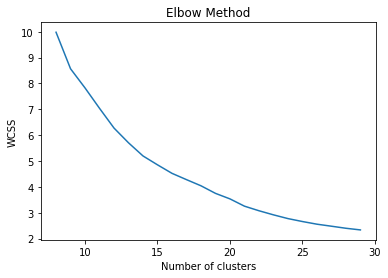

In [163]:
# Using the elbow method to figure out the best number of clusters
wcss = []
for i in range(8,30):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(scaled_km_reg_out)
    wcss.append(kmeans.inertia_)
plt.plot(range(8,30), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

**Elbow values to verify using SC - 8,9,12,13,14 & 21.**

In [165]:
kmeans_8 = KMeans(n_clusters=8, init='k-means++', max_iter=300, n_init=10, random_state=42)
km_8 = kmeans_8.fit(scaled_km_reg_out)
kmeans_9 = KMeans(n_clusters=9, init='k-means++', max_iter=300, n_init=10, random_state=42)
km_9 = kmeans_9.fit(scaled_km_reg_out)
kmeans_13 = KMeans(n_clusters=13, init='k-means++', max_iter=300, n_init=10, random_state=42)
km_13 = kmeans_13.fit(scaled_km_reg_out)
kmeans_14 = KMeans(n_clusters=14, init='k-means++', max_iter=300, n_init=10, random_state=42)
km_14 = kmeans_14.fit(scaled_km_reg_out)

In [166]:
print("Silhoutte Score 8 clusters: ",metrics.silhouette_score(scaled_km_reg_out, km_8.labels_))
print("Silhoutte Score 9 clusters: ",metrics.silhouette_score(scaled_km_reg_out, km_9.labels_))
print("Silhoutte Score 13 clusters: ",metrics.silhouette_score(scaled_km_reg_out, km_13.labels_))
print("Silhoutte Score 14 clusters: ",metrics.silhouette_score(scaled_km_reg_out, km_14.labels_))


Silhoutte Score 8 clusters:  0.4254991240027884
Silhoutte Score 9 clusters:  0.43876085495337847
Silhoutte Score 13 clusters:  0.4449754970571696
Silhoutte Score 14 clusters:  0.44211658044370933


In [167]:
kmeans_21 = KMeans(n_clusters=21, init='k-means++', max_iter=300, n_init=10, random_state=42)
km_21 = kmeans_21.fit(scaled_km_reg_out)
print("Silhoutte Score 21 clusters: ",metrics.silhouette_score(scaled_km_reg_out, km_21.labels_))


Silhoutte Score 21 clusters:  0.3717905322778264


In [169]:
kmeans_12 = KMeans(n_clusters=12, init='k-means++', max_iter=300, n_init=10, random_state=42)
km_12 = kmeans_12.fit(scaled_km_reg_out)
print("Silhoutte Score 12 clusters: ",metrics.silhouette_score(scaled_km_reg_out, km_12.labels_))

Silhoutte Score 12 clusters:  0.4477083182743504


12 clusters have the best SC, we will use this going forward

In [170]:
km_reg_out['cluster'] = km_12.labels_

In [171]:
out_reg['cluster'] = km_12.labels_

In [172]:
# Checking how many of the providers each cluster hold
km_reg_out.cluster.value_counts()*100/sum(km_reg_out.cluster.value_counts())

4     43.614794
8     17.794836
2     11.165387
5      7.117934
7      6.001396
1      4.815073
0      4.466155
3      2.023726
6      1.116539
11     0.976971
9      0.558269
10     0.348918
Name: cluster, dtype: float64

In [173]:
size=pd.concat([pd.Series(km_reg_out.cluster.size), pd.Series.sort_index(km_reg_out.cluster.value_counts())])
Seg_size=pd.DataFrame(size, columns=['Seg_size'])
Seg_Pct = pd.DataFrame(size/km_reg_out.cluster.size, columns=['Seg_Pct'])

In [174]:
Profling_output_reg_out = pd.concat([km_reg_out.apply(lambda x: x.mean()).T,
                             km_reg_out.groupby('cluster').apply(lambda x: x.mean()).T],axis=1)

Profling_output_reg_out=pd.concat([Seg_size.T, Seg_Pct.T, Profling_output_reg_out], axis=0)
Profling_output_reg_out

,0,0,1,2,3,4,5,6,7,8,9,10,11
Seg_size,1433.000000,64.000000,69.000000,160.000000,29.000000,625.000000,102.000000,16.000000,86.000000,255.000000,8.000000,5.000000,14.000000
Seg_Pct,1.000000,0.044662,0.048151,0.111654,0.020237,0.436148,0.071179,0.011165,0.060014,0.177948,0.005583,0.003489,0.009770
Outpatient Services,17796.168876,94558.375000,9758.927536,12273.143750,280.241379,9002.499200,10881.676471,261604.375000,4495.360465,5043.854902,525826.000000,331.600000,126.071429
Average Estimated Submitted Charges,1353.090770,244.139715,4766.899255,1807.973326,6571.933074,322.297758,2906.123718,213.828908,2969.119824,981.611287,190.063866,10466.525778,3841.856326
Average Total Payments,289.113418,78.585989,694.895833,435.435348,1407.131932,81.476414,480.704878,76.843497,778.856726,210.197431,73.936053,1484.100995,1504.825828
payout_diff,1063.977352,165.553726,4072.003421,1372.537978,5164.801141,240.821344,2425.418840,136.985410,2190.263098,771.413856,116.127814,8982.424783,2337.030498
cluster,4.535939,0.000000,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000,10.000000,11.000000


In [175]:
Profling_output_reg_out.columns = ['Overall','Cluster1', 'Cluster2', 'Cluster3', 'Cluster4','Cluster5', 'Cluster6', 'Cluster7',
                           'Cluster8','Cluster9','Cluster10','Cluster11','Cluster12']
Profling_output_reg_out.to_excel("analysis_result/outpatient_region_cluster.xlsx")

In [176]:
out_reg[out_reg['cluster']==10]

,Provider State,APC,Outpatient Services,Average Estimated Submitted Charges,Average Total Payments,payout_diff,cluster
27,AL,0074 - Level IV Endoscopy Upper Airway,156,8870.949523,1340.175179,7530.774344,10
116,CA,0074 - Level IV Endoscopy Upper Airway,763,13000.481322,1692.298854,11308.182468,10
204,DC,0074 - Level IV Endoscopy Upper Airway,76,8874.664424,1535.486589,7339.177835,10
256,FL,0074 - Level IV Endoscopy Upper Airway,621,11742.189054,1421.739163,10320.449891,10
454,KS,0074 - Level IV Endoscopy Upper Airway,42,9844.344568,1430.805192,8413.539375,10


**Cluster 11** are most different. These are the cluster of regions where the providers tend to have the highest disparity between submitted charges and reimbursements.